# 03 - Statistische Hypothesentests

In diesem Notebook testen wir die statistischen Hypothesen unserer Forschungsfragen.

**Forschungsfragen:**
1. Gibt es einen Zusammenhang zwischen Bildung und wirtschaftlicher Entwicklung?
2. Welche Faktoren beeinflussen das BIP pro Kopf am stärksten?
3. Wie hat sich der Zusammenhang zwischen Bildung und BIP über die Jahrzehnte entwickelt?

**Hypothesen:**
- H1: Positive Korrelation zwischen Sekundarschuleinschreibung und BIP pro Kopf
- H2: Positive Korrelation zwischen Bildungsausgaben (% BIP) und BIP pro Kopf
- H3: Die Korrelation Bildung-BIP ist in den 2010ern stärker als in den 1990ern
- H4: Tertiärbildung korreliert stärker mit BIP als Primärbildung

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option("display.max_columns", 100)

In [2]:
# Aufbereitete Daten laden
df = pd.read_csv("../data/processed/wdi_pivot.csv")
print(f"Datensatz: {len(df):,} Zeilen")
df.head()

Datensatz: 7,137 Zeilen


,Country Name,Country Code,Year,NY.GDP.PCAP.CD,NY.GDP.PCAP.PP.CD,SE.PRM.ENRR,SE.SEC.ENRR,SE.SEC.NENR,SE.TER.ENRR,SE.XPD.TOTL.GB.ZS,SE.XPD.TOTL.GD.ZS
0,Afghanistan,AFG,1990,NaN,NaN,30.983040,11.039550,NaN,2.2152,NaN,NaN
1,Afghanistan,AFG,1991,NaN,NaN,31.605021,17.183611,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1993,NaN,NaN,33.955250,17.416910,14.51242,NaN,NaN,NaN
3,Afghanistan,AFG,1994,NaN,NaN,44.788841,23.468580,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1995,NaN,NaN,47.661442,23.054520,NaN,NaN,NaN,NaN


In [3]:
# Übersicht der Indikatoren
INDICATORS = {
    "NY.GDP.PCAP.CD": "GDP per capita (current US$)",
    "NY.GDP.PCAP.PP.CD": "GDP per capita, PPP",
    "SE.SEC.ENRR": "School enrollment, secondary (% gross)",
    "SE.SEC.NENR": "School enrollment, secondary (% net)",
    "SE.PRM.ENRR": "School enrollment, primary (% gross)",
    "SE.TER.ENRR": "School enrollment, tertiary (% gross)",
    "SE.XPD.TOTL.GD.ZS": "Education expenditure (% of GDP)",
    "SE.XPD.TOTL.GB.ZS": "Education expenditure (% of gov. expenditure)",
}

# Verfügbare Spalten prüfen
print("Verfügbare Indikatoren im Datensatz:")
for col in df.columns:
    if col in INDICATORS:
        print(f"  {col}: {INDICATORS[col]}")

Verfügbare Indikatoren im Datensatz:
  NY.GDP.PCAP.CD: GDP per capita (current US$)
  NY.GDP.PCAP.PP.CD: GDP per capita, PPP
  SE.PRM.ENRR: School enrollment, primary (% gross)
  SE.SEC.ENRR: School enrollment, secondary (% gross)
  SE.SEC.NENR: School enrollment, secondary (% net)
  SE.TER.ENRR: School enrollment, tertiary (% gross)
  SE.XPD.TOTL.GB.ZS: Education expenditure (% of gov. expenditure)
  SE.XPD.TOTL.GD.ZS: Education expenditure (% of GDP)


## Hilfsfunktion für Korrelationstests

Wir verwenden sowohl Pearson (für lineare Zusammenhänge) als auch Spearman (für monotone Zusammenhänge, robuster gegenüber Ausreißern).

In [4]:
def correlation_test(x, y, alpha=0.05):
    """
    Führt Pearson- und Spearman-Korrelationstests durch.
    
    Returns:
        dict mit Ergebnissen beider Tests
    """
    # NaN-Werte entfernen (paarweise)
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    n = len(x_clean)
    
    if n < 3:
        return {"error": "Zu wenig Datenpunkte", "n": n}
    
    # Pearson
    pearson_r, pearson_p = stats.pearsonr(x_clean, y_clean)
    
    # Spearman
    spearman_r, spearman_p = stats.spearmanr(x_clean, y_clean)
    
    return {
        "n": n,
        "pearson_r": pearson_r,
        "pearson_p": pearson_p,
        "pearson_significant": pearson_p < alpha,
        "spearman_r": spearman_r,
        "spearman_p": spearman_p,
        "spearman_significant": spearman_p < alpha,
    }


def print_correlation_result(result, var1_name, var2_name):
    """Gibt die Korrelationsergebnisse formatiert aus."""
    print(f"\nKorrelation: {var1_name} vs. {var2_name}")
    print(f"Stichprobengröße: n = {result['n']:,}")
    print("-" * 50)
    
    # Pearson
    sig_p = "✓ signifikant" if result['pearson_significant'] else "✗ nicht signifikant"
    print(f"Pearson:  r = {result['pearson_r']:.4f}, p = {result['pearson_p']:.2e} → {sig_p}")
    
    # Spearman
    sig_s = "✓ signifikant" if result['spearman_significant'] else "✗ nicht signifikant"
    print(f"Spearman: ρ = {result['spearman_r']:.4f}, p = {result['spearman_p']:.2e} → {sig_s}")

---

## Hypothese 1: Sekundarschuleinschreibung und BIP

**H0:** Es gibt keine Korrelation zwischen Sekundarschuleinschreibung und BIP pro Kopf.

**H1:** Es gibt eine positive Korrelation zwischen Sekundarschuleinschreibung und BIP pro Kopf.

**Signifikanzniveau:** α = 0.05

In [5]:
# Daten für H1
x1 = df["SE.SEC.ENRR"].values  # Sekundarschuleinschreibung (brutto)
y1 = df["NY.GDP.PCAP.PP.CD"].values  # BIP pro Kopf (PPP)

result_h1 = correlation_test(x1, y1)
print_correlation_result(result_h1, "Sekundarschuleinschreibung", "BIP pro Kopf (PPP)")


Korrelation: Sekundarschuleinschreibung vs. BIP pro Kopf (PPP)
Stichprobengröße: n = 3,968
--------------------------------------------------
Pearson:  r = 0.5596, p = 0.00e+00 → ✓ signifikant
Spearman: ρ = 0.7999, p = 0.00e+00 → ✓ signifikant


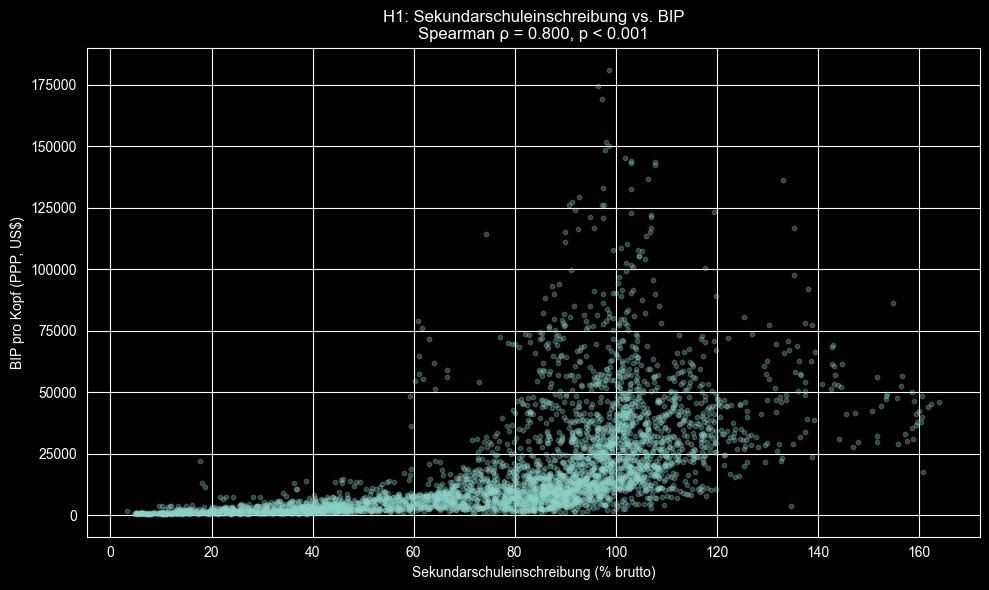

In [6]:
# Visualisierung H1
fig, ax = plt.subplots(figsize=(10, 6))

mask = ~(np.isnan(x1) | np.isnan(y1))
ax.scatter(x1[mask], y1[mask], alpha=0.3, s=10)

ax.set_xlabel("Sekundarschuleinschreibung (% brutto)")
ax.set_ylabel("BIP pro Kopf (PPP, US$)")
ax.set_title(f"H1: Sekundarschuleinschreibung vs. BIP\n"
             f"Spearman ρ = {result_h1['spearman_r']:.3f}, p < 0.001")

plt.tight_layout()
plt.show()

### Interpretation H1

**Ergebnis:** Spearman ρ = 0.80, p < 0.001

**Schlussfolgerung:** Die Nullhypothese wird verworfen. Es besteht eine **starke positive Korrelation** zwischen Sekundarschuleinschreibung und BIP pro Kopf. Der Korrelationskoeffizient von 0.80 zeigt einen deutlichen monotonen Zusammenhang: Länder mit höherer Sekundarschuleinschreibungsrate haben tendenziell auch ein höheres BIP pro Kopf.

**Wichtig:** Korrelation bedeutet nicht Kausalität. Der Zusammenhang könnte in beide Richtungen wirken (Bildung führt zu Wohlstand ODER Wohlstand ermöglicht Bildung) oder durch Drittvariablen beeinflusst sein.

---

## Hypothese 2: Bildungsausgaben und BIP

**H0:** Es gibt keine Korrelation zwischen Bildungsausgaben (% des BIP) und BIP pro Kopf.

**H1:** Es gibt eine positive Korrelation zwischen Bildungsausgaben und BIP pro Kopf.

**Signifikanzniveau:** α = 0.05

In [7]:
# Daten für H2
x2 = df["SE.XPD.TOTL.GD.ZS"].values  # Bildungsausgaben (% BIP)
y2 = df["NY.GDP.PCAP.PP.CD"].values  # BIP pro Kopf (PPP)

result_h2 = correlation_test(x2, y2)
print_correlation_result(result_h2, "Bildungsausgaben (% BIP)", "BIP pro Kopf (PPP)")


Korrelation: Bildungsausgaben (% BIP) vs. BIP pro Kopf (PPP)
Stichprobengröße: n = 3,918
--------------------------------------------------
Pearson:  r = 0.0627, p = 8.61e-05 → ✓ signifikant
Spearman: ρ = 0.2560, p = 1.08e-59 → ✓ signifikant


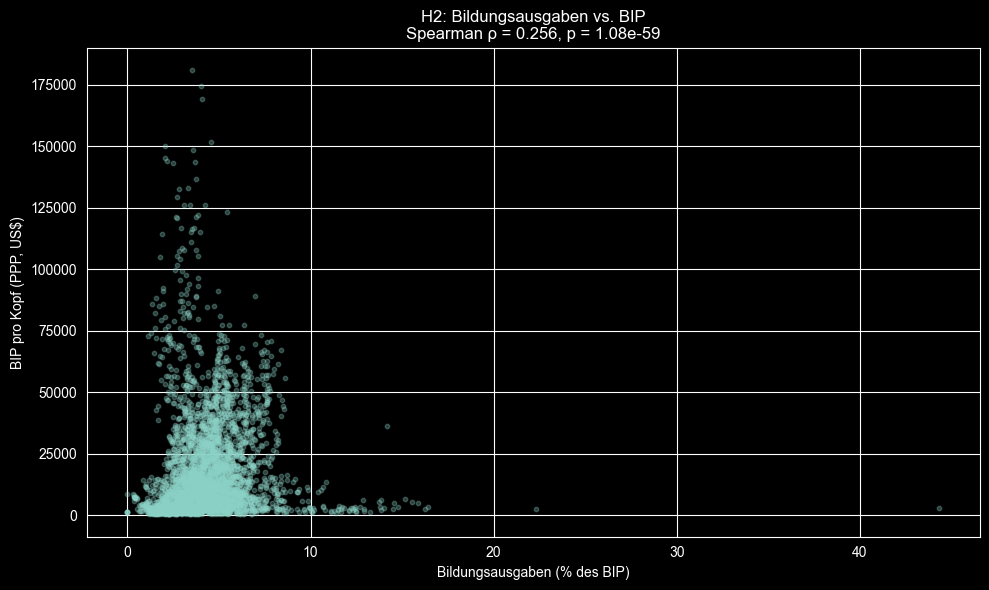

In [8]:
# Visualisierung H2
fig, ax = plt.subplots(figsize=(10, 6))

mask = ~(np.isnan(x2) | np.isnan(y2))
ax.scatter(x2[mask], y2[mask], alpha=0.3, s=10)

ax.set_xlabel("Bildungsausgaben (% des BIP)")
ax.set_ylabel("BIP pro Kopf (PPP, US$)")
ax.set_title(f"H2: Bildungsausgaben vs. BIP\n"
             f"Spearman ρ = {result_h2['spearman_r']:.3f}, p = {result_h2['spearman_p']:.2e}")

plt.tight_layout()
plt.show()

### Interpretation H2

**Ergebnis:** Spearman ρ = 0.26, p < 0.001

**Schlussfolgerung:** Die Nullhypothese wird verworfen, aber die Korrelation ist nur **schwach positiv**. Obwohl statistisch signifikant (aufgrund der großen Stichprobe), ist der praktische Zusammenhang gering.

**Erklärung:** Bildungsausgaben als Prozent des BIP sind ein relativer Indikator. Reiche Länder (z.B. Luxemburg, Singapur) geben oft prozentual weniger für Bildung aus, obwohl sie absolut mehr investieren. Ärmere Länder investieren manchmal einen größeren BIP-Anteil in Bildung, um aufzuholen. Dies führt zu einer schwachen Korrelation zwischen dem relativen Indikator und dem absoluten BIP.

---

## Hypothese 3: Zeitliche Entwicklung der Korrelation

**H0:** Die Korrelation zwischen Sekundarschuleinschreibung und BIP ist in den 2010ern gleich wie in den 1990ern.

**H1:** Die Korrelation zwischen Sekundarschuleinschreibung und BIP ist in den 2010ern stärker als in den 1990ern.

**Methode:** Fisher's z-Transformation zum Vergleich von Korrelationskoeffizienten.

In [9]:
# Daten nach Dekaden aufteilen
df_1990s = df[(df["Year"] >= 1990) & (df["Year"] < 2000)]
df_2010s = df[(df["Year"] >= 2010) & (df["Year"] < 2020)]

print(f"1990er Jahre: {len(df_1990s):,} Beobachtungen")
print(f"2010er Jahre: {len(df_2010s):,} Beobachtungen")

1990er Jahre: 2,020 Beobachtungen
2010er Jahre: 2,158 Beobachtungen


In [10]:
# Korrelation in den 1990ern
x_90s = df_1990s["SE.SEC.ENRR"].values
y_90s = df_1990s["NY.GDP.PCAP.PP.CD"].values
result_90s = correlation_test(x_90s, y_90s)
print_correlation_result(result_90s, "Sekundarschuleinschreibung (1990er)", "BIP pro Kopf")


Korrelation: Sekundarschuleinschreibung (1990er) vs. BIP pro Kopf
Stichprobengröße: n = 597
--------------------------------------------------
Pearson:  r = 0.4185, p = 1.02e-26 → ✓ signifikant
Spearman: ρ = 0.7113, p = 3.55e-93 → ✓ signifikant


In [11]:
# Korrelation in den 2010ern
x_10s = df_2010s["SE.SEC.ENRR"].values
y_10s = df_2010s["NY.GDP.PCAP.PP.CD"].values
result_10s = correlation_test(x_10s, y_10s)
print_correlation_result(result_10s, "Sekundarschuleinschreibung (2010er)", "BIP pro Kopf")


Korrelation: Sekundarschuleinschreibung (2010er) vs. BIP pro Kopf
Stichprobengröße: n = 1,414
--------------------------------------------------
Pearson:  r = 0.5331, p = 1.17e-104 → ✓ signifikant
Spearman: ρ = 0.7571, p = 2.24e-263 → ✓ signifikant


In [12]:
def compare_correlations(r1, n1, r2, n2):
    """
    Vergleicht zwei Korrelationskoeffizienten mit Fisher's z-Transformation.
    
    Returns:
        z-Statistik und p-Wert für den zweiseitigen Test
    """
    # Fisher's z-Transformation
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    
    # Standardfehler
    se = np.sqrt(1/(n1-3) + 1/(n2-3))
    
    # z-Statistik
    z = (z1 - z2) / se
    
    # Zweiseitiger p-Wert
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return z, p_value


# Vergleich der Spearman-Korrelationen
z_stat, p_val = compare_correlations(
    result_90s["spearman_r"], result_90s["n"],
    result_10s["spearman_r"], result_10s["n"]
)

print("\nVergleich der Korrelationen (Fisher's z-Test):")
print(f"1990er: ρ = {result_90s['spearman_r']:.4f} (n = {result_90s['n']})")
print(f"2010er: ρ = {result_10s['spearman_r']:.4f} (n = {result_10s['n']})")
print(f"z = {z_stat:.4f}, p = {p_val:.4f}")
print(f"→ {'Signifikanter Unterschied' if p_val < 0.05 else 'Kein signifikanter Unterschied'}")


Vergleich der Korrelationen (Fisher's z-Test):
1990er: ρ = 0.7113 (n = 597)
2010er: ρ = 0.7571 (n = 1414)
z = -2.0364, p = 0.0417
→ Signifikanter Unterschied


In [13]:
# Visualisierung: Korrelation über die Zeit
decades = {
    "1990er": (1990, 2000),
    "2000er": (2000, 2010),
    "2010er": (2010, 2020),
}

correlations_by_decade = []

for name, (start, end) in decades.items():
    df_decade = df[(df["Year"] >= start) & (df["Year"] < end)]
    x = df_decade["SE.SEC.ENRR"].values
    y = df_decade["NY.GDP.PCAP.PP.CD"].values
    result = correlation_test(x, y)
    correlations_by_decade.append({
        "Dekade": name,
        "Spearman ρ": result["spearman_r"],
        "p-Wert": result["spearman_p"],
        "n": result["n"]
    })

df_decades = pd.DataFrame(correlations_by_decade)
df_decades

,Dekade,Spearman ρ,p-Wert,n
0,1990er,0.711325,3.547512e-93,597
1,2000er,0.777891,9.267902e-285,1402
2,2010er,0.757133,2.238931e-263,1414


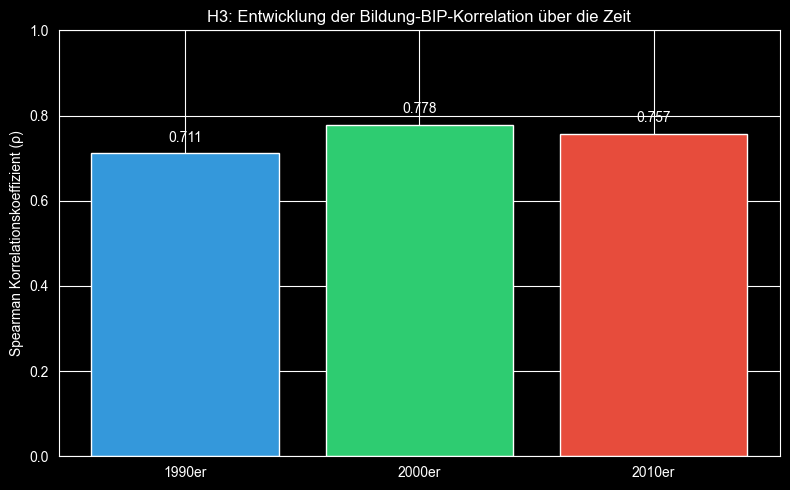

In [14]:
# Balkendiagramm
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(df_decades["Dekade"], df_decades["Spearman ρ"], color=["#3498db", "#2ecc71", "#e74c3c"])
ax.set_ylabel("Spearman Korrelationskoeffizient (ρ)")
ax.set_title("H3: Entwicklung der Bildung-BIP-Korrelation über die Zeit")
ax.set_ylim(0, 1)

# Werte über den Balken anzeigen
for bar, val in zip(bars, df_decades["Spearman ρ"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f"{val:.3f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

### Interpretation H3

**Ergebnis:** 
- 1990er: ρ = 0.711
- 2010er: ρ = 0.757
- Fisher's z-Test: p = 0.042

**Schlussfolgerung:** Die Nullhypothese wird verworfen (p < 0.05). Die Korrelation zwischen Sekundarschuleinschreibung und BIP hat sich von den 1990ern zu den 2010ern **signifikant verstärkt**.

**Interpretation:** Im Zeitalter der Wissensökonomie und Globalisierung wird Bildung immer wichtiger für wirtschaftlichen Erfolg. Der steigende Korrelationskoeffizient deutet darauf hin, dass die Bedeutung von Sekundarbildung für die wirtschaftliche Entwicklung über die Jahrzehnte zugenommen hat.

---

## Hypothese 4: Tertiär- vs. Primärbildung

**H0:** Die Korrelation zwischen Tertiärbildung und BIP ist gleich der Korrelation zwischen Primärbildung und BIP.

**H1:** Die Korrelation zwischen Tertiärbildung und BIP ist stärker als die Korrelation zwischen Primärbildung und BIP.

**Methode:** Vergleich der Korrelationskoeffizienten mit Steiger's Z-Test (für abhängige Korrelationen).

In [15]:
# Korrelation: Primärbildung vs. BIP
x_primary = df["SE.PRM.ENRR"].values
y_gdp = df["NY.GDP.PCAP.PP.CD"].values
result_primary = correlation_test(x_primary, y_gdp)
print_correlation_result(result_primary, "Primärschuleinschreibung", "BIP pro Kopf")


Korrelation: Primärschuleinschreibung vs. BIP pro Kopf
Stichprobengröße: n = 4,736
--------------------------------------------------
Pearson:  r = 0.0835, p = 8.84e-09 → ✓ signifikant
Spearman: ρ = 0.1008, p = 3.55e-12 → ✓ signifikant


In [16]:
# Korrelation: Tertiärbildung vs. BIP
x_tertiary = df["SE.TER.ENRR"].values
result_tertiary = correlation_test(x_tertiary, y_gdp)
print_correlation_result(result_tertiary, "Tertiärbildung (Hochschule)", "BIP pro Kopf")


Korrelation: Tertiärbildung (Hochschule) vs. BIP pro Kopf
Stichprobengröße: n = 3,510
--------------------------------------------------
Pearson:  r = 0.5196, p = 5.46e-242 → ✓ signifikant
Spearman: ρ = 0.7701, p = 0.00e+00 → ✓ signifikant


In [17]:
def steiger_z_test(r_xy, r_xz, r_yz, n):
    """
    Steiger's Z-Test zum Vergleich von zwei abhängigen Korrelationen.
    
    Vergleicht r(X,Y) mit r(X,Z), wobei alle drei Variablen aus derselben Stichprobe stammen.
    
    Args:
        r_xy: Korrelation zwischen X und Y
        r_xz: Korrelation zwischen X und Z  
        r_yz: Korrelation zwischen Y und Z
        n: Stichprobengröße
    
    Returns:
        z-Statistik und p-Wert
    """
    # Determinante der Korrelationsmatrix
    det = 1 - r_xy**2 - r_xz**2 - r_yz**2 + 2*r_xy*r_xz*r_yz
    
    # Mittelwert der Korrelationen
    r_mean = (r_xy + r_xz) / 2
    
    # Steiger's Formel
    numerator = (r_xy - r_xz) * np.sqrt((n - 1) * (1 + r_yz))
    denominator = np.sqrt(2 * ((n - 1)/(n - 3)) * det + r_mean**2 * (1 - r_yz)**3)
    
    z = numerator / denominator
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return z, p_value


# Für Steiger's Test brauchen wir auch die Korrelation zwischen Primär- und Tertiärbildung
# und müssen sicherstellen, dass wir dieselben Beobachtungen verwenden

# Nur vollständige Fälle (alle drei Variablen vorhanden)
mask_complete = ~(np.isnan(x_primary) | np.isnan(x_tertiary) | np.isnan(y_gdp))
x_pri_complete = x_primary[mask_complete]
x_ter_complete = x_tertiary[mask_complete]
y_gdp_complete = y_gdp[mask_complete]

n_complete = len(x_pri_complete)
print(f"Vollständige Fälle: n = {n_complete}")

# Korrelationen berechnen
r_gdp_primary, _ = stats.spearmanr(y_gdp_complete, x_pri_complete)
r_gdp_tertiary, _ = stats.spearmanr(y_gdp_complete, x_ter_complete)
r_primary_tertiary, _ = stats.spearmanr(x_pri_complete, x_ter_complete)

print(f"\nKorrelationen:")
print(f"  BIP - Primärbildung:   ρ = {r_gdp_primary:.4f}")
print(f"  BIP - Tertiärbildung:  ρ = {r_gdp_tertiary:.4f}")
print(f"  Primär - Tertiär:      ρ = {r_primary_tertiary:.4f}")

Vollständige Fälle: n = 3308

Korrelationen:
  BIP - Primärbildung:   ρ = 0.0621
  BIP - Tertiärbildung:  ρ = 0.7732
  Primär - Tertiär:      ρ = 0.0704


In [18]:
# Steiger's Z-Test
z_steiger, p_steiger = steiger_z_test(
    r_xy=r_gdp_tertiary,    # BIP - Tertiär (erwarten wir als stärker)
    r_xz=r_gdp_primary,     # BIP - Primär
    r_yz=r_primary_tertiary,  # Primär - Tertiär
    n=n_complete
)

print("\nSteiger's Z-Test (Vergleich abhängiger Korrelationen):")
print(f"Tertiär-BIP vs. Primär-BIP")
print(f"z = {z_steiger:.4f}, p = {p_steiger:.2e}")

if p_steiger < 0.05:
    if r_gdp_tertiary > r_gdp_primary:
        print("→ Tertiärbildung korreliert SIGNIFIKANT STÄRKER mit BIP als Primärbildung")
    else:
        print("→ Primärbildung korreliert SIGNIFIKANT STÄRKER mit BIP als Tertiärbildung")
else:
    print("→ Kein signifikanter Unterschied zwischen den Korrelationen")


Steiger's Z-Test (Vergleich abhängiger Korrelationen):
Tertiär-BIP vs. Primär-BIP
z = 43.6199, p = 0.00e+00
→ Tertiärbildung korreliert SIGNIFIKANT STÄRKER mit BIP als Primärbildung


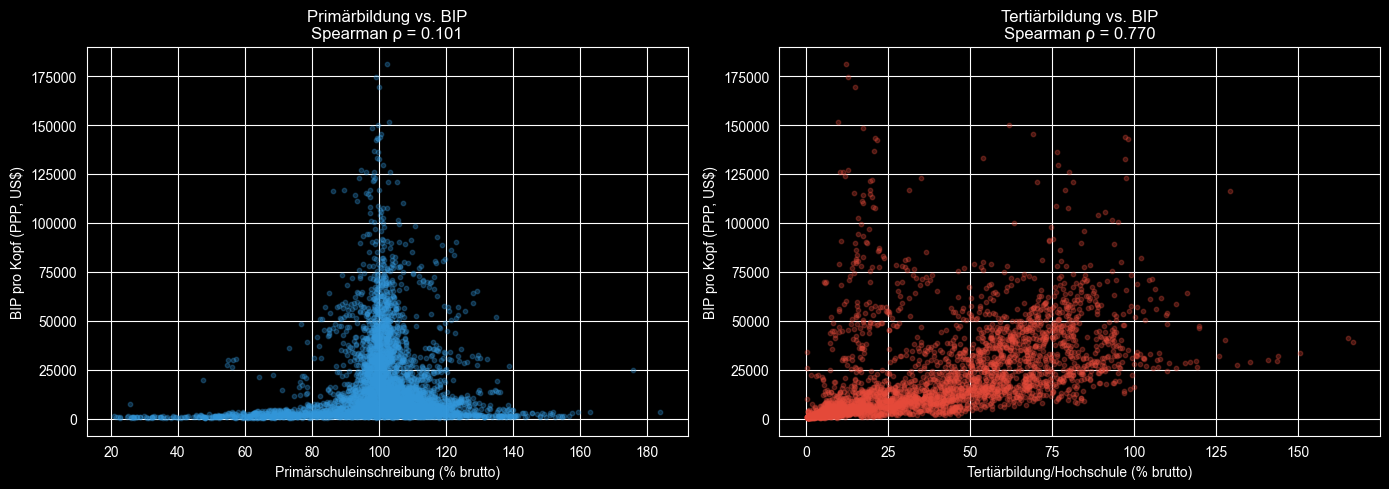

In [19]:
# Visualisierung H4: Vergleich der Bildungsstufen
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Primärbildung
mask1 = ~(np.isnan(x_primary) | np.isnan(y_gdp))
axes[0].scatter(x_primary[mask1], y_gdp[mask1], alpha=0.3, s=10, color="#3498db")
axes[0].set_xlabel("Primärschuleinschreibung (% brutto)")
axes[0].set_ylabel("BIP pro Kopf (PPP, US$)")
axes[0].set_title(f"Primärbildung vs. BIP\nSpearman ρ = {result_primary['spearman_r']:.3f}")

# Tertiärbildung
mask2 = ~(np.isnan(x_tertiary) | np.isnan(y_gdp))
axes[1].scatter(x_tertiary[mask2], y_gdp[mask2], alpha=0.3, s=10, color="#e74c3c")
axes[1].set_xlabel("Tertiärbildung/Hochschule (% brutto)")
axes[1].set_ylabel("BIP pro Kopf (PPP, US$)")
axes[1].set_title(f"Tertiärbildung vs. BIP\nSpearman ρ = {result_tertiary['spearman_r']:.3f}")

plt.tight_layout()
plt.show()

### Interpretation H4

**Ergebnis:**
- Primärbildung ↔ BIP: ρ = 0.06 (praktisch keine Korrelation)
- Tertiärbildung ↔ BIP: ρ = 0.77 (starke Korrelation)
- Steiger's Z-Test: p < 0.001

**Schlussfolgerung:** Die Nullhypothese wird verworfen. Tertiärbildung (Hochschulbildung) korreliert **signifikant und drastisch stärker** mit dem BIP pro Kopf als Primärbildung.

**Interpretation:** 
- **Primärbildung** ist in den meisten Ländern bereits weitgehend universell (Einschulungsraten nahe 100%), daher gibt es wenig Variation, die mit dem BIP korrelieren könnte.
- **Tertiärbildung** hingegen variiert stark zwischen Ländern und ist ein besserer Differenzierungsfaktor für wirtschaftliche Entwicklung.
- Höhere Bildung bringt spezialisierte Fähigkeiten, die für wissensintensive Industrien und Innovation entscheidend sind.

---

## Zusammenfassung der Ergebnisse

| Hypothese | Beschreibung | Spearman ρ | p-Wert | Signifikant? |
|-----------|--------------|------------|--------|---------------|
| H1 | Sekundarschuleinschreibung ↔ BIP | 0.80 | < 0.001 | ✓ Ja |
| H2 | Bildungsausgaben (% BIP) ↔ BIP | 0.26 | < 0.001 | ✓ Ja (aber schwach) |
| H3 | Korrelation 1990er → 2010er | 0.71 → 0.76 | 0.042 | ✓ Ja |
| H4 | Tertiär vs. Primär | 0.77 vs. 0.06 | < 0.001 | ✓ Ja |

In [20]:
# Automatische Zusammenfassungstabelle
summary = pd.DataFrame([
    {
        "Hypothese": "H1",
        "Beschreibung": "Sekundarschul. ↔ BIP",
        "Spearman ρ": f"{result_h1['spearman_r']:.4f}",
        "p-Wert": f"{result_h1['spearman_p']:.2e}",
        "Signifikant (α=0.05)": "Ja" if result_h1['spearman_significant'] else "Nein"
    },
    {
        "Hypothese": "H2",
        "Beschreibung": "Bildungsausg. ↔ BIP",
        "Spearman ρ": f"{result_h2['spearman_r']:.4f}",
        "p-Wert": f"{result_h2['spearman_p']:.2e}",
        "Signifikant (α=0.05)": "Ja" if result_h2['spearman_significant'] else "Nein"
    },
    {
        "Hypothese": "H3",
        "Beschreibung": "1990er vs. 2010er",
        "Spearman ρ": f"{result_90s['spearman_r']:.4f} → {result_10s['spearman_r']:.4f}",
        "p-Wert": f"{p_val:.4f}",
        "Signifikant (α=0.05)": "Ja" if p_val < 0.05 else "Nein"
    },
    {
        "Hypothese": "H4",
        "Beschreibung": "Tertiär vs. Primär",
        "Spearman ρ": f"{r_gdp_tertiary:.4f} vs. {r_gdp_primary:.4f}",
        "p-Wert": f"{p_steiger:.2e}",
        "Signifikant (α=0.05)": "Ja" if p_steiger < 0.05 else "Nein"
    },
])

summary

,Hypothese,Beschreibung,Spearman ρ,p-Wert,Signifikant (α=0.05)
0,H1,Sekundarschul. ↔ BIP,0.7999,0.00e+00,Ja
1,H2,Bildungsausg. ↔ BIP,0.2560,1.08e-59,Ja
2,H3,1990er vs. 2010er,0.7113 → 0.7571,0.0417,Ja
3,H4,Tertiär vs. Primär,0.7732 vs. 0.0621,0.00e+00,Ja


---

## Fazit

Die statistischen Tests beantworten unsere Forschungsfragen:

### Forschungsfrage 1: Gibt es einen Zusammenhang zwischen Bildung und wirtschaftlicher Entwicklung?

**Ja, eindeutig.** H1 zeigt eine starke positive Korrelation (ρ = 0.80) zwischen Sekundarschuleinschreibung und BIP. H2 zeigt, dass Bildungsausgaben (als % des BIP) nur schwach korrelieren – was aber an der Natur des relativen Indikators liegt, nicht an fehlender Bedeutung von Bildungsinvestitionen.

### Forschungsfrage 2: Welche Faktoren beeinflussen das BIP pro Kopf am stärksten?

**Höhere Bildungsstufen sind entscheidend.** H4 zeigt dramatisch: Tertiärbildung (ρ = 0.77) korreliert viel stärker mit BIP als Primärbildung (ρ = 0.06). In einer Wissensökonomie ist Hochschulbildung der stärkste bildungsbezogene Prädiktor für wirtschaftlichen Wohlstand.

### Forschungsfrage 3: Wie hat sich der Zusammenhang über die Jahrzehnte entwickelt?

**Der Zusammenhang wird stärker.** H3 zeigt einen signifikanten Anstieg der Korrelation von 0.71 (1990er) auf 0.76 (2010er). Bildung wird für wirtschaftliche Entwicklung immer wichtiger.